In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import subprocess

benchmark_path = "../../../build/experiments/pure_eigen_openmp/pure_eigen_openmp"
csv_path = "/tmp/bench.csv"

outputs = []

for i in range(5):
    print(f"Outer iteration: {i + 1}")
    for mem_sync in ("false", "true"):
        for mem_type in ("dynamic", "static"):
            for cores in range(1, 12):
                subprocess.call(
                    [benchmark_path, str(cores), csv_path, mem_sync, mem_type]
                )
                outputs.append(pd.read_csv(csv_path))

df = pd.concat(outputs)

Outer iteration: 0
Outer iteration: 1
Outer iteration: 2
Outer iteration: 3
Outer iteration: 4


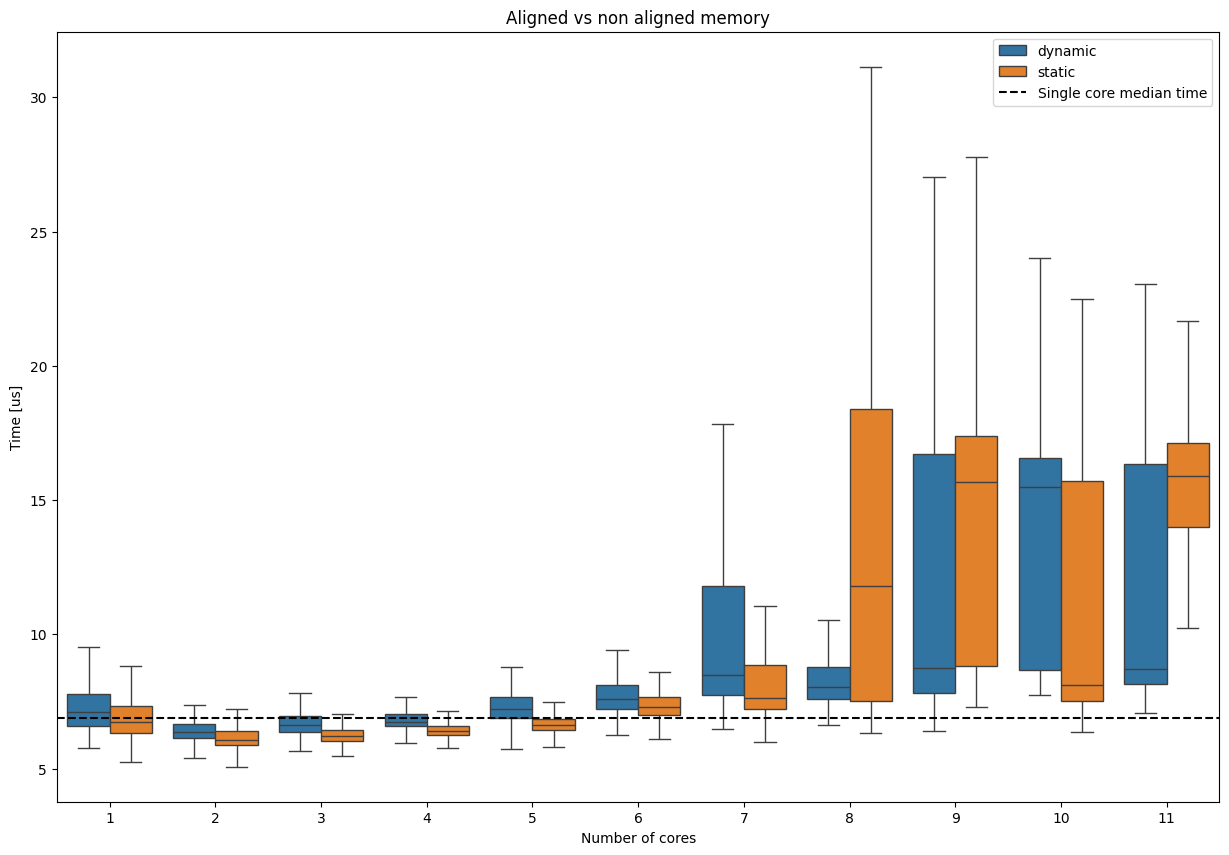

In [3]:
fig, axs = plt.subplots(1, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

sync_mem = False

sns.boxplot(
    data=df[df["sync_mem"] == sync_mem],
    x="nthreads",
    y="time",
    hue="alignment",
    showfliers=False,
    ax=axs,
)

line = df[(df["nthreads"] == 1) & (df["sync_mem"] == sync_mem)]["time"].median()
axs.axhline(y=line, color="k", linestyle="--", label="Single core median time")

axs.set(
    xlabel="Number of cores",
    ylabel="Time [us]",
    title="Aligned vs non aligned memory",
)

legend = axs.legend()